In [1]:
import tqdm
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union
from tabulate import tabulate
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# from sklearnex import patch_sklearn, config_context


In [2]:
DIABETIC_DATA = "../data/diabetic_data.csv"
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
df = pd.read_csv(DIABETIC_DATA)
# df.head(5)

In [3]:
df.duplicated(subset = ['patient_nbr']).sum()
df['patient_nbr'].value_counts()

# Check the number of patients with unique entries
df['patient_nbr'].value_counts()[df['patient_nbr'].value_counts() == 1].shape[0]

# Check the number of patients with multiple entries
df['patient_nbr'].value_counts()[df['patient_nbr'].value_counts() != 1].shape[0]

16773

In [4]:
# Keep the latest record
df.drop_duplicates(subset = ['patient_nbr'], keep = 'last', inplace = True)

# now we will remove the patient-number column
df.drop(['patient_nbr'], axis=1, inplace=True)

In [5]:
df.replace("?", np.nan, inplace=True)

In [6]:
def replace_values_with_nan(df, replacements):
    for column, values in replacements.items():
        for value in values:
            df[column] = df[column].replace(value, np.nan)

    df[list(replacements.keys())] = df[list(replacements.keys())].astype('object')
    
    return df

replacements = {
    'admission_type_id': [5, 6, 8],
    'discharge_disposition_id': [18, 25, 26],
    'admission_source_id': [9, 15, 17, 20, 21]
}

df = replace_values_with_nan(df, replacements)

In [7]:
df.isnull().sum()

encounter_id                    0
race                         1878
gender                          0
age                             0
weight                      68671
admission_type_id            7444
discharge_disposition_id     2964
admission_source_id          5133
time_in_hospital                0
payer_code                  30085
medical_specialty           34525
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         17
diag_2                        290
diag_3                       1146
number_diagnoses                0
max_glu_serum               68041
A1Cresult                   59120
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide     

In [8]:
def get_null_percentage(df):
    percent_null_per_column = df.isnull().sum() / df.shape[0] * 100
    results = [[column, percent_null] for column, percent_null in percent_null_per_column.items() if percent_null > 0]
    results.sort(key=lambda x: x[1], reverse=True)
    return results

def display_null_percentage(null_percentage):
    formatted_results = [[col, f"{val:.2f}%"] for col, val in null_percentage]
    print(tabulate(formatted_results, headers=["Column", "Percentage of Null Values"], tablefmt="grid"))

null_percentage = get_null_percentage(df)

In [9]:
def drop_columns_with_high_null(df, null_percentage, threshold=80):
    columns_to_drop = [col for col, percent_null in null_percentage if percent_null > threshold]
    df.drop(columns_to_drop, axis=1, inplace=True)
    print("Dropped columns with more than", threshold, "percent null values:")
    print(columns_to_drop)

drop_columns_with_high_null(df, null_percentage)

Dropped columns with more than 80 percent null values:
['weight', 'max_glu_serum', 'A1Cresult']


In [10]:
all_columns = df.select_dtypes(include=["object"]).columns.tolist()
ordinal_columns = ["age"]
label_columns = [col for col in all_columns if col not in ordinal_columns]


In [11]:
imputer = SimpleImputer(strategy="most_frequent")

for col in all_columns:
    df.loc[:, col] = imputer.fit_transform(df[col].values.reshape(-1, 1))

In [12]:
df.isnull().sum().sum()

0

In [13]:
label_encoders = {}

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Ordinal columns encoding
for col in ordinal_columns:
    ordinal_encoder = LabelEncoder()
    df[col] = ordinal_encoder.fit_transform(df[col])

# Label columns encoding
for col in label_columns:
    if col not in label_encoders:
        label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])


In [14]:
df.drop_duplicates(inplace=True)

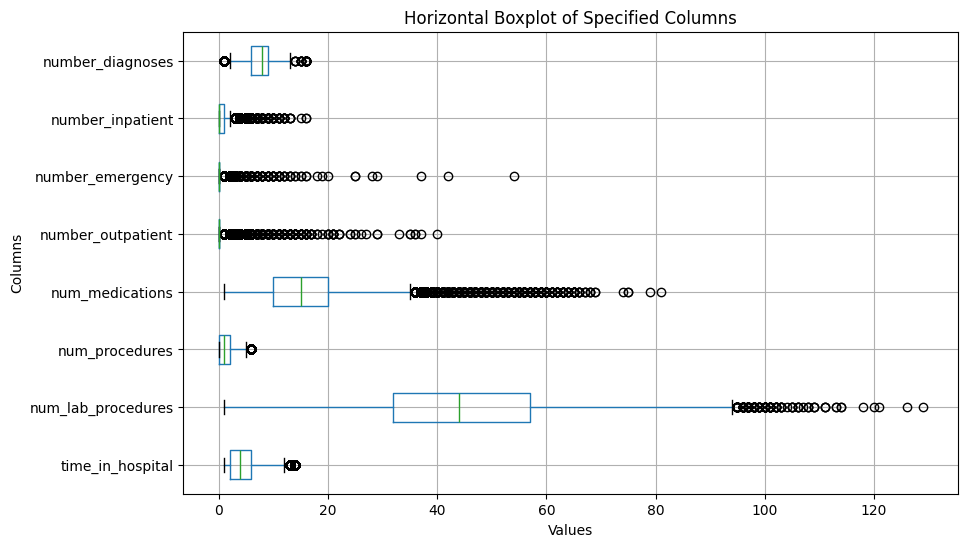

In [15]:
def delete_outliers(df: pd.DataFrame, columns: list[str], threshold: float) -> pd.DataFrame:
    clf = IsolationForest(contamination=threshold)
    outliers = clf.fit_predict(df[columns])
    return df.loc[outliers == 1]

def plot_horizontal_boxplot(df, columns):
    plt.figure(figsize=(10, 6))
    df[columns].boxplot(vert=0)
    plt.title('Horizontal Boxplot of Specified Columns')
    plt.xlabel('Values')
    plt.ylabel('Columns')
    plt.show()

plot_horizontal_boxplot(df, ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'])

In [16]:
df = delete_outliers(df, df.select_dtypes(include=["int64", "float64"]).columns.tolist(), 0.1)

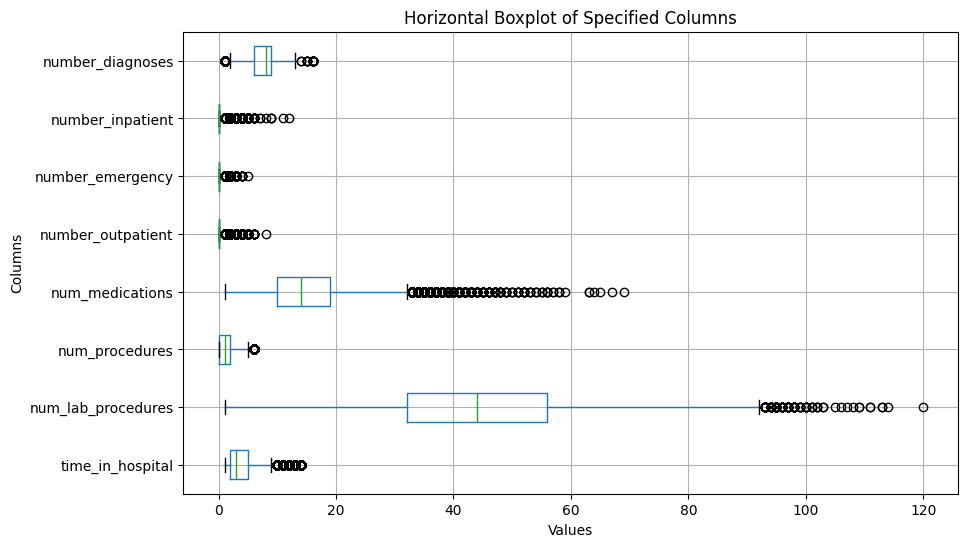

In [17]:
plot_horizontal_boxplot(df, ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'])

In [18]:
X = df

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=3) # n_components=10
X_pca = pca.fit_transform(X)

# explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
# n_components_to_explain_80_percent = (explained_variance_ratio_cumsum <= 0.8).sum() + 1

# pca = PCA(n_components=n_components_to_explain_80_percent)
# X_pca = pca.fit_transform(X)



In [19]:
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
n_components_to_explain_80_percent = (explained_variance_ratio_cumsum <= 0.8).sum() + 1

pca = PCA(n_components=n_components_to_explain_80_percent)
X_pca = pca.fit_transform(X)


In [20]:
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio: 0.4036881022589262


In [21]:
kmean_params = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "init": ["k-means++"],
}

kmean_grid = ParameterGrid(kmean_params)

In [22]:
silhouette_scores = []

for params in tqdm.tqdm(kmean_grid):
    # with config_context(target_offload="gpu:0"):
    kmeans = KMeans(**params)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    
best_params = list(kmean_grid)[np.argmax(silhouette_scores)]

100%|██████████| 9/9 [07:11<00:00, 47.97s/it]


In [23]:
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {np.max(silhouette_scores)}")

Best Parameters: {'init': 'k-means++', 'n_clusters': 3}
Best Silhouette Score: 0.6593357241680615


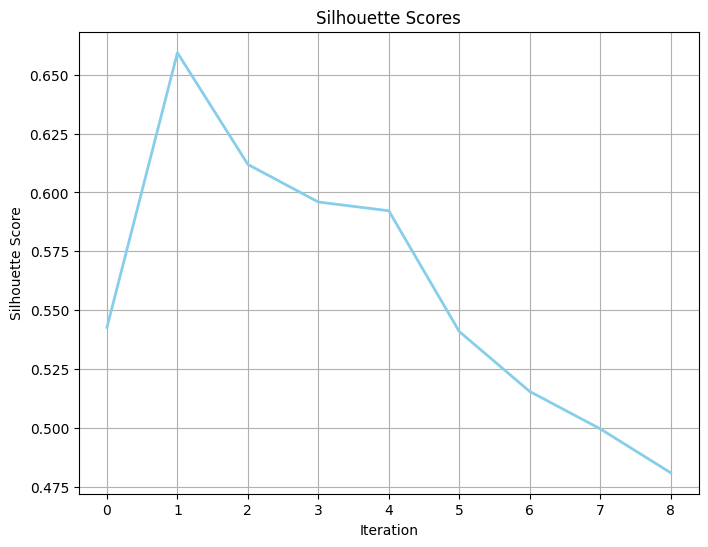

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(silhouette_scores, color="skyblue", lw=2)
plt.title("Silhouette Scores")
plt.xlabel("Iteration")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [25]:
# Clustering
best_kmeans = KMeans(**best_params)
best_kmeans.fit(X_pca)

KMeans(n_clusters=3)

In [26]:
with open("../models/best_kmeans.pkl", "wb") as f:
    pickle.dump(best_kmeans, f)

In [27]:
db_params = {
    "eps": [0.4, 0.5],
    "min_samples": [5, 10],
    # "eps": [0.1, 0.2, 0.3, 0.4, 0.5],
    # "min_samples": [5, 10, 20, 25],
}

db_grid = ParameterGrid(db_params)

In [28]:
silhouette_scores = []

for params in tqdm.tqdm(db_grid):
    # with config_context(target_offload="gpu:0"):
    db = DBSCAN(**params)
    db.fit(X_pca)
    labels = db.labels_
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    
best_params = list(db_grid)[np.argmax(silhouette_scores)]

100%|██████████| 4/4 [04:36<00:00, 69.08s/it]


In [29]:
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {np.max(silhouette_scores)}")

Best Parameters: {'eps': 0.4, 'min_samples': 5}
Best Silhouette Score: 0.6593357241680615


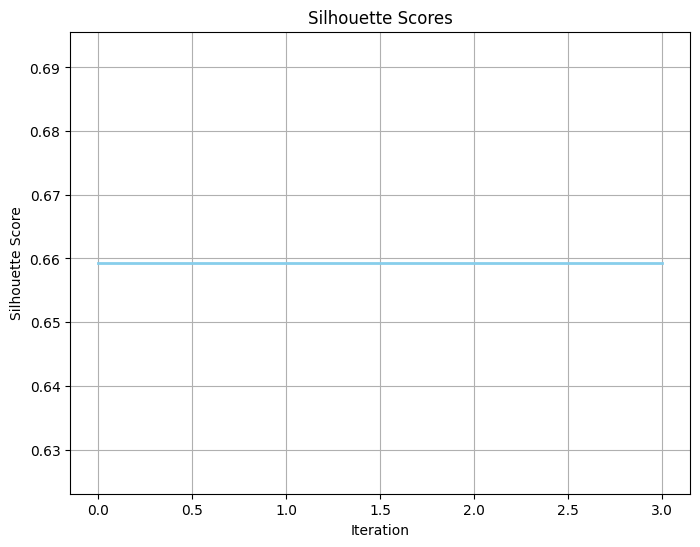

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(silhouette_scores, color="skyblue", lw=2)
plt.title("Silhouette Scores")
plt.xlabel("Iteration")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [31]:
best_db = DBSCAN(**best_params)
best_db.fit(X_pca)

DBSCAN(eps=0.4)

In [32]:
with open("../models/best_db.pkl", "wb") as f:
    pickle.dump(best_db, f)

In [33]:
with open("../models/best_kmeans.pkl", "rb") as f:
    best_kmeans = pickle.load(f)
    
with open("../models/best_db.pkl", "rb") as f:
    best_db = pickle.load(f)

In [34]:
with open("../result/result.csv", "w") as f:
    kmeans_labels = best_kmeans.labels_
    db_labels = best_db.labels_
    f.write("id_encounter,kmeans_label,dbscan_label\n")
    ids = df["encounter_id"].values
    for i in range(len(ids)):
        f.write(f"{ids[i]},{kmeans_labels[i]},{db_labels[i]}\n")

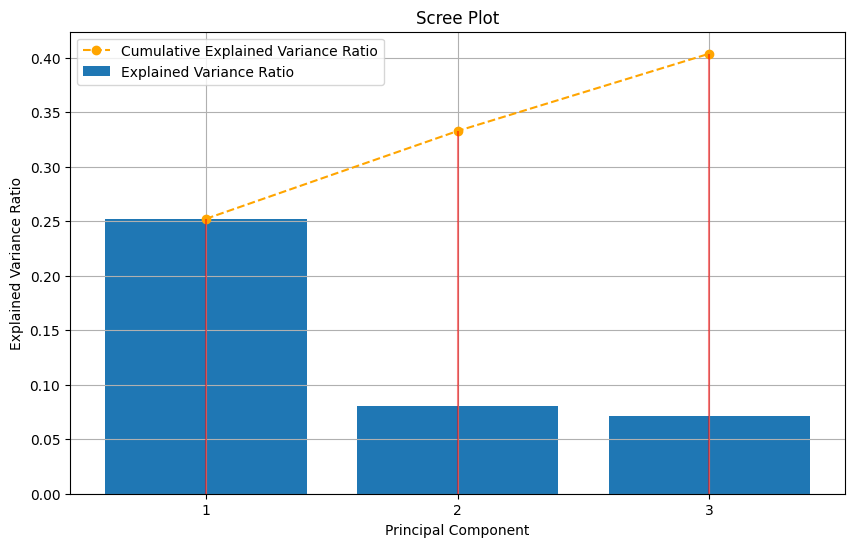

In [35]:
def plot_scree_plot(explained_variance_ratio):
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color='orange', label='Cumulative Explained Variance Ratio')
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Explained Variance Ratio')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
    plt.grid(True)
    plt.legend()

    for i in range(len(explained_variance_ratio)):
        plt.vlines(x=i + 1, ymin=0, ymax=cumulative_variance_ratio[i], colors='red', alpha=0.5)

    plt.show()

plot_scree_plot(pca.explained_variance_ratio_)


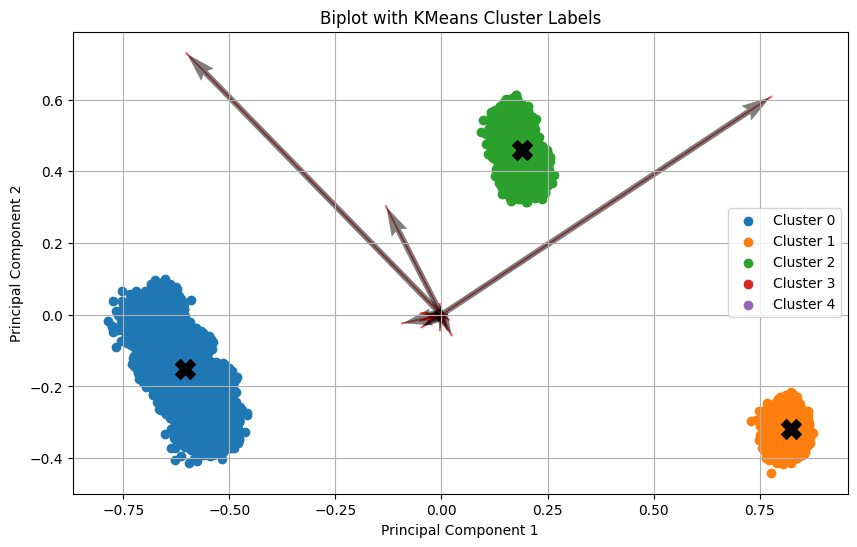

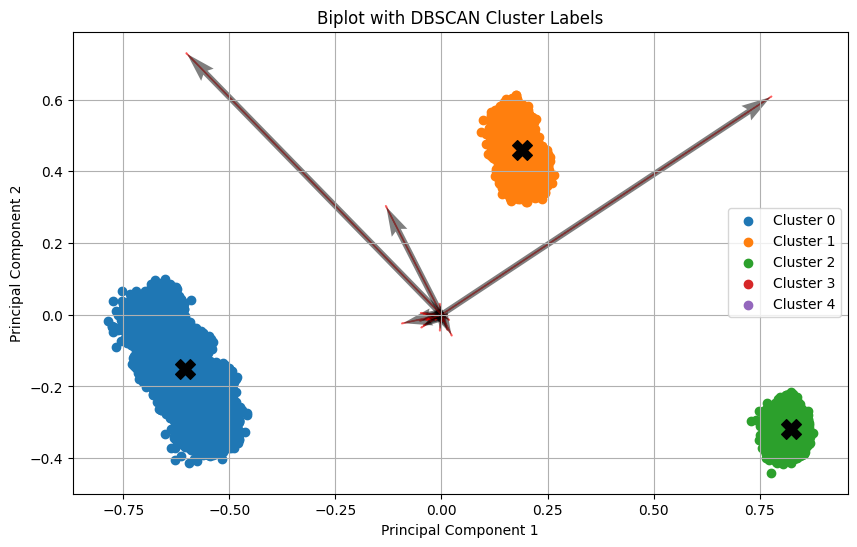

In [36]:
def plot_biplot_with_clusters(X_pca, labels, pca_components, clustering_method, n_clusters=5):
    plt.figure(figsize=(10, 6))

    # Scatter plot of data points
    for cluster_label in range(n_clusters):
        # if (cluster_label == 0 or cluster_label == 1 or cluster_label == 2):
            # continue
        plt.scatter(X_pca[labels == cluster_label, 0],
                   X_pca[labels == cluster_label, 1],
                   label=f'Cluster {cluster_label}')

    # Calculate and plot cluster centers
    for cluster_label in range(n_clusters):
        cluster_center = np.mean(X_pca[labels == cluster_label], axis=0)
        plt.scatter(cluster_center[0], cluster_center[1], s=200, c='black', marker='X')
    

    # Biplot arrows
    for i, (component1, component2) in enumerate(zip(pca_components[0], pca_components[1])):
        plt.arrow(0, 0, component1, component2, color='r', alpha=0.5)
        plt.quiver(0, 0, component1, component2, angles='xy', scale_units='xy', scale=1, alpha=0.5)
        # plt.text(component1 * 1.15, component2 * 1.15, f'PC{i+1}', ha='center', va='center')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'Biplot with {clustering_method} Cluster Labels')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_biplot_with_clusters(X_pca, best_kmeans.labels_, pca.components_, "KMeans")

plot_biplot_with_clusters(X_pca, best_db.labels_, pca.components_, "DBSCAN")


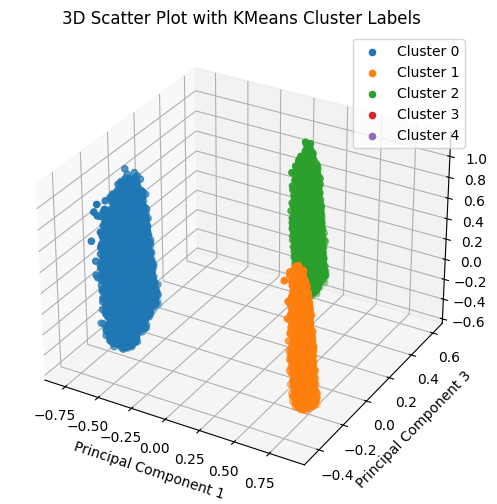

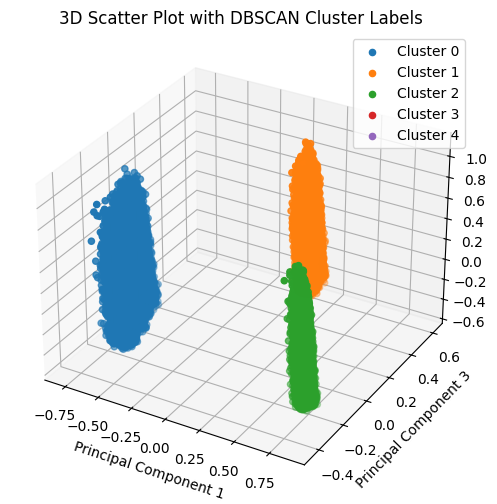

In [37]:
def plot_3d_scatter_with_clusters(X_pca, labels, clustering_method, n_clusters=5):
     # Plotting
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # palette = sns.color_palette("pastel", n_colors=n_clusters)
    # palette = sns.color_palette("RdBu", n_colors=n_clusters)
    # palette = sns.color_palette("Blues", n_colors=n_clusters)
    # palette = sns.color_palette("Set3", n_colors=n_clusters)    

    for cluster_label in range(n_clusters):
        # if (cluster_label == 0 or cluster_label == 1 or cluster_label == 2):
            # continue
        ax.scatter(X_pca[labels == cluster_label, 0],
                   X_pca[labels == cluster_label, 1],
                   X_pca[labels == cluster_label, 2],
                   label=f'Cluster {cluster_label}')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.ylabel('Principal Component 3')
    ax.set_title(f'3D Scatter Plot with {clustering_method} Cluster Labels')

    ax.legend()
    plt.show()

plot_3d_scatter_with_clusters(X_pca, best_kmeans.labels_, "KMeans")

plot_3d_scatter_with_clusters(X_pca, best_db.labels_, "DBSCAN")
